In [7]:
#----------------------------------------------------------------------
# create_noisy_dataset.py
#
# Create a noisy signal with given properties
#
# Created: September 6, 2018 - Daniel M Newman -- danielnewman@gatech.edu
#
# Modified:
#   * Septermber 6, 2018 - DMN
#            - Added documentation for this script
#----------------------------------------------------------------------

import numpy as np
import warnings
import json
import sys
from ML_Train.DBQuerier import DBQuerier as Querier

# import libraries
import os
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)

import glob
from datetime import datetime


import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from scipy.signal import welch
from crawlab_toolbox.freq_tools import welch_stat
from scipy.stats import describe

from DBInserter import DBInserter

from crawlab_toolbox import plotting as genplt
plt.rcParams['figure.figsize'] = (15, 4)


In [8]:
def create_noisy_signal(
    duration, samplingRate, frequencies, amplitudes,
    noiseStDev, phase, 
    frequencyError=0.05, harmonics=1,
    saveSignal=False,fileName='signal'):
    '''
    create_noisy_signal

    Create a signal with desired randomness and spectral qualities.

    Inputs:
        - duration: time (in seconds) captured by the signal
        - samplingRate: rate (in Hz) of the signal
        - frequencies: list of frequencies in the signal
        - amplitudes: amplitudes of the corresponding frequencies
        - (float) noiseStDev: standard deviation squared) of
                the gaussian noise added to the signal
        - (float) frequencyStDev: standard deviation
                of the gaussian noise added to the frequency
        - (float) amplitudeStDev: standard deviation
                of the gaussian noise added to the amplitudes
        - (float) phaseStDev: StDev (standard deviation squared) of
                the gaussian noise added to the phase of the signal

    '''

    # determine the required number of datapoints to cover the duration
    # at the required sampling rate
    numPoints = int(duration * samplingRate)

    # Create a time array with the correct start and endpoint, sampled at
    # the required sampling rates
    time = np.atleast_2d(np.linspace(0,duration,numPoints))

    # Ensure that all of the inputs are cast as numpy arrays
    freqs = np.atleast_2d(np.asarray(frequencies).flatten()).T
    amps = np.atleast_2d(np.asarray(amplitudes).flatten()).T
    noiseStDev = np.asarray(noiseStDev)

    # Modify the signal slightly
    m, n = freqs.shape
#     phase = np.atleast_2d(phaseStDev * np.random.random((m, n)))

    # Create randomly distributed noise with a given standard deviation
    noise = noiseStDev * np.random.random(numPoints)

    # The number of input frequencies must be identical to the number
    # of input amplitudes
    if len(freqs) != len(amps):
        raise ValueError('Length of input frequencies must be identical to\
                          that of input amplitudes')

    signal = np.sum(amps * np.sin(2 * np.pi * freqs * time + phase), axis=0) + noise

    if saveSignal:
        fName = fileName + '.txt'
        timeName = fileName + '_time.txt'
        np.savetxt(fName, np.round(signal,6), header='Signal', delimiter=',')
        np.savetxt(timeName, np.round(time,6), header='Time (s)', delimiter=',')

    return time.flatten(), signal

In [9]:
def parse_data(data,samplingRate,fftPoints,assetId,sensorId,vibrationState):
    
    currDate = datetime.now()
    datetime_string = currDate.strftime('%Y-%m-%d %H:%M:%S.%f')
    
    freqs,amps = welch(data.T,fs=samplingRate,nperseg=fftPoints)
    
    this_rms = np.sqrt(1 / np.array(data).shape[0] * np.sum(np.array(data)**2,axis=0))
    
    _,minmax,mean,variance,skewness,kurtosis = describe(data)

    NyquistFrequency = 0.5 * samplingRate

    frequencyInterval = freqs[1] - freqs[0]

    sampleRMS = np.sqrt(1 / data.shape[0] * np.sum(data**2,axis=0))

    inserter.insert_value('RMS',
                          datetime_string,
                          assetId,
                          sensorId,
                          np.round(sampleRMS,5))
    inserter.insert_value('VibrationMean',
                          datetime_string,
                          assetId,
                          sensorId,
                          np.round(mean,5))
    inserter.insert_value('VibrationKurtosis',
                          datetime_string,
                          assetId,
                          sensorId,
                          np.round(kurtosis,5))
    inserter.insert_value('VibrationSkewness',
                          datetime_string,
                          assetId,
                          sensorId,
                          np.round(skewness,5))
    inserter.insert_value('VibrationVariance',
                          datetime_string,
                          assetId,
                          sensorId,
                          np.round(variance,5))
    inserter.insert_vib_state(
                      datetime_string,
                      assetId,
                      vibrationState,
                      'Simulate')
    inserter.insert_fft(datetime_string,
                        assetId,
                        sensorId,
                        np.array2string(amps.flatten(),precision=5,separator=','),
                        frequencyInterval)
#     inserter.insert_vibration(datetime_string,
#                         assetId,
#                         sensorId,
#                         np.array2string(data.flatten(),precision=5,separator=','),
#                         1 / samplingRate)

#     inserter.insert_fft_std(datetime_string,
#                             assetId,
#                             sensorId,
#                             np.array2string(stdevs.flatten(),precision=5,separator=','),
#                             frequencyInterval)

In [10]:
samplingRate = 8192
duration = 1
fftPoints = 2048

NyquistFreq = 0.5 * samplingRate

amplitudes = np.linspace(0.1,2.5,10)
frequencies = np.linspace(0.1 * NyquistFreq, 0.3 * NyquistFreq,10)
noiseStdDev = np.linspace(0.1,0.1,1)

sampleRepetitions = 7

phase = np.linspace(-np.pi/2,np.pi/2,25)

assetId = 'Example-NoNoise-VaryAmplitude-VaryPhase'
database = 'db18'
# inserter = DBInserter(database)

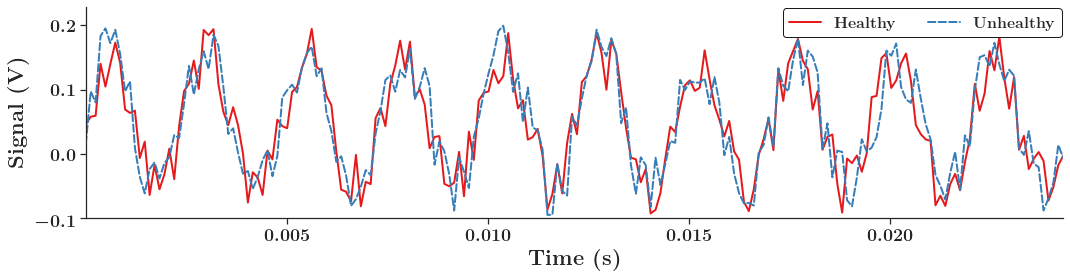

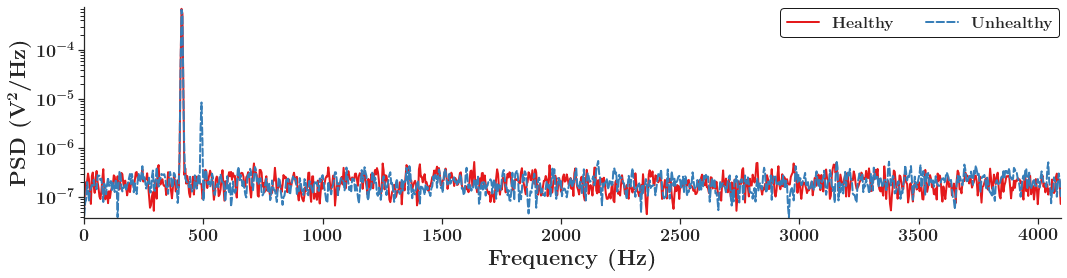

In [28]:
thisTime,unhealthySignal = create_noisy_signal(1,samplingRate,[frequencies[0],frequencies[0]*1.2],[amplitudes[0],0.1*amplitudes[0]],noiseStdDev[0],0,)
thisTime,healthySignal = create_noisy_signal(1,samplingRate,[frequencies[0]],[amplitudes[0]],noiseStdDev[0],0,)

# plt.plot(thisSignal)
# plt.show()


# combine the responses and labels to put on our 2D plot
responses = np.vstack((healthySignal,unhealthySignal))
labels = [r'Healthy','Unhealthy']

numPoints = 200

# Create a 2D plot
genplt.generate_plot(thisTime[:200], # X - coordinate on the plot
              responses[:,:200],# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Time (s)',# X - axis label
              'Signal (V)',   # Y - axis label
              filename='Test_Signal',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=False,
                     ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='publication',
              file_type='png'
             )

freqs,healthyAmps = welch(healthySignal.T,fs=samplingRate,nperseg=fftPoints)
freqs,unhealthyAmps = welch(unhealthySignal.T,fs=samplingRate,nperseg=fftPoints)




# combine the responses and labels to put on our 2D plot
responses = np.vstack((healthyAmps,unhealthyAmps))
labels = [r'Healthy','Unhealthy']

# Create a 2D plot
genplt.generate_plot(freqs, # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              r'PSD $(\mathrm{V}^2/\mathrm{Hz})$',   # Y - axis label
              filename='Test_Signal_FFT',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=True,
                     ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='publication',
              file_type='png'
             )

In [16]:
# Create Training Data
for i in range(len(amplitudes)):
    thisAmp = amplitudes[i]
    for j in range(len(frequencies)):
        thisFreq = frequencies[j]
        for k in range(len(noiseStdDev)):
            thisNoise = noiseStdDev[k]
            
            sensorId = 'SNR-{}'.format(np.round(thisAmp / thisNoise,3))
            vibrationState = 'Healthy'
            
            for l in range(sampleRepetitions):

                _,signal = create_noisy_signal(duration,samplingRate,thisFreq,thisAmp,thisNoise,0,)

                parse_data(signal,samplingRate,fftPoints,assetId,sensorId,vibrationState)

NameError: name 'inserter' is not defined

In [42]:
# Create Training Data
for i in range(len(amplitudes)):
    thisAmp = amplitudes[i]
    for j in range(len(frequencies)):
        thisFreq = frequencies[j]
        for k in range(len(noiseStdDev)):
            thisNoise = noiseStdDev[k]
            
            sensorId = 'SNR-{}'.format(np.round(thisAmp / thisNoise,3))
            vibrationState = 'Unhealthy'
            
            for l in range(sampleRepetitions):

                _,signal = create_noisy_signal(duration,
                                               samplingRate,
                                               [thisFreq,thisFreq*1.4],
                                               [thisAmp,thisAmp*0.1],
                                               thisNoise,0,)

                parse_data(signal,samplingRate,fftPoints,assetId,sensorId,vibrationState)

In [38]:
# assetId = 'Simulated Data (No Noise)'
querier = Querier('db18','Simulate')
# assetId = 'Simulated Data (With Noise)'
if reset == True:
    querier.execute_query('DELETE FROM `' + database + '`.`FFTSTD` WHERE assetId = "' + assetId + '";')
    querier.execute_query('DELETE FROM `' + database + '`.`FFT` WHERE assetId =  "' + assetId + '";')
    querier.execute_query('DELETE FROM `' + database + '`.`RMS` WHERE assetId =  "' + assetId + '";')
    querier.execute_query('DELETE FROM `' + database + '`.`VibrationMean` WHERE assetId =  "' + assetId + '";')
    querier.execute_query('DELETE FROM `' + database + '`.`VibrationSkewness` WHERE assetId =  "' + assetId + '";')
    querier.execute_query('DELETE FROM `' + database + '`.`VibrationVariance` WHERE assetId =  "' + assetId + '";')
    querier.execute_query('DELETE FROM `' + database + '`.`VibrationKurtosis` WHERE assetId =  "' + assetId + '";')
    querier.execute_query('DELETE FROM `' + database + '`.`Vibration` WHERE assetId =  "' + assetId + '";')
    reset = False


In [37]:
reset = True

In [7]:
# Create Test data

thisAmp = 4.0
assetId = 'Simulated Data (No Noise - Test_1)'
noiseStdDev = np.linspace(1e-12,1,1)

for j in range(len(frequencies)):
    thisFreq = frequencies[j]
    for k in range(len(noiseStdDev)):
        thisNoise = noiseStdDev[k]

        sensorId = 'SNR-{}'.format(np.round(thisAmp / thisNoise,3))
        vibrationState = '{} Hz'.format(np.round(thisFreq,3))

        for l in range(sampleRepetitions):

            _,signal = create_noisy_signal(duration,samplingRate,thisFreq,thisAmp,thisNoise,phase[l],)

            parse_data(signal,samplingRate,fftPoints,assetId,sensorId,vibrationState) 